## Image Classification with TensorFlow

Notebook to show method of image classification using tensorflow Convolutional Neural Network (CNN) capability, as well as the ability to implement transfer learning using a network already trained on color images (Inception network). A model accuracy of 83% is achieved. Classification data is obtained from the The CIFAR-10 dataset.

In [1]:
import seaborn as sns
sns.set()
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras.utils import to_categorical as one_hot
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
import pickle
import glob
%matplotlib notebook

2023-05-29 21:09:23.239851: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def unpickle(file):
    with open(file, 'rb') as f:
        dict = pickle.load(f, encoding='latin1')
    return dict

In [3]:
def get_data(files):
    
    images = []
    labels = []
    for f in files:
        data = unpickle(f)
        images_R = data['data'][:,:3072//3].reshape((10000, 32, 32))
        images_G = data['data'][:,3072//3:2*3072//3].reshape((10000, 32, 32))
        images_B = data['data'][:,2*3072//3:3072].reshape((10000, 32, 32))
        
        images.append(np.asarray([images_R, images_G, images_B]).transpose((1, 2, 3, 0)))
        labels.append(np.asarray(data['labels']))
        
    images = np.concatenate(images)
    labels = np.concatenate(labels)
    return images, labels


In [4]:
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

In [5]:
files = glob.glob('data/cifar-10-batches-py/data_batch_*')

In [6]:
train_images, train_labels = get_data(files)
validation_images, validation_labels = get_data(['data/cifar-10-batches-py/test_batch'])

<IPython.core.display.Javascript object>


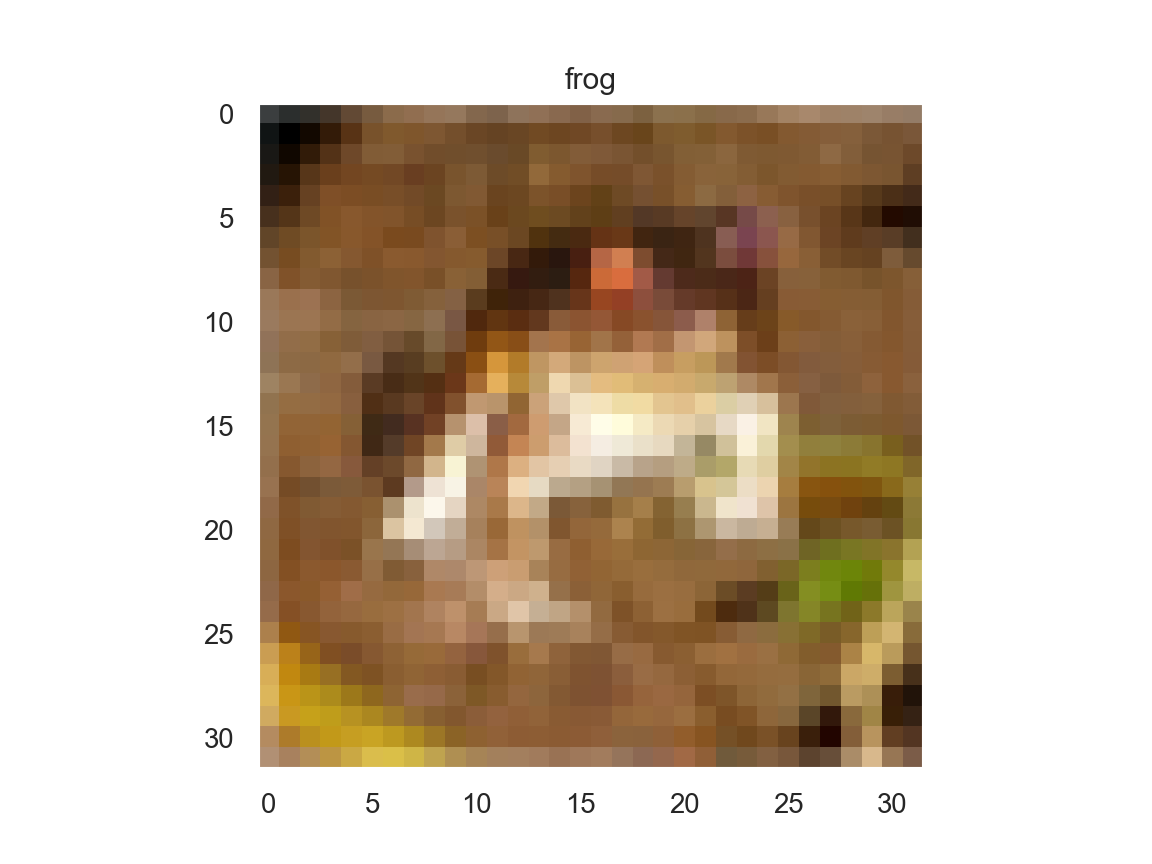

In [7]:
i = 0
plt.figure()
plt.rcParams["axes.grid"] = False  #  Remove the grid lines from the image.
plt.imshow(train_images[i])
plt.title(label_names[train_labels[i]])
plt.show()

In [8]:
x_train = train_images / 255
y_train = train_labels
y_train = tf.one_hot(y_train, 10).numpy()

x_test = validation_images / 255
y_test = validation_labels
y_test = tf.one_hot(y_test, 10).numpy()

In [10]:
# Model parameters
img_size = 32
n_classes = 10
n_channels = 3
filt_size = [5, 5] # 5x5 pixel filters
batch_size = 50
n_epochs = 100
n_filters = 32
stride = 1
drop_rate = 0.5
hidden_size = 100

In [11]:
model = keras.models.Sequential()

In [13]:
model.add(keras.layers.Reshape([img_size, img_size, n_channels]))
model.add(keras.layers.Conv2D(n_filters, filt_size, padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='same'))
model.add(keras.layers.Conv2D(2*n_filters, filt_size, padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='same'))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dropout(drop_rate))
model.add(keras.layers.Dense(hidden_size, activation='relu')) 
model.add(keras.layers.Dense(n_classes, activation='softmax')) 

In [144]:
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.SGD(learning_rate=0.1), #adam seems to do worse, does it just take longer to converge?
              metrics=['accuracy'])

In [145]:
checkpointer = keras.callbacks.ModelCheckpoint(filepath='./models/keras_example.hdf5',
                                               monitor='val_loss',
                                               verbose=1, save_best_only=True)
earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, min_delta=.01) 

In [146]:
%%time
history = model.fit(x_train, y_train,
                    epochs=n_epochs,
                    batch_size=batch_size,
                    callbacks=[checkpointer, earlystopping],
                    validation_data=(x_test,y_test))

Epoch 1/100
1000/1000 [==============================] - ETA: 0s - loss: 1.8108 - accuracy: 0.3413
Epoch 1: val_loss improved from inf to 1.39111, saving model to ./models/keras_example.hdf5
1000/1000 [==============================] - 64s 63ms/step - loss: 1.8108 - accuracy: 0.3413 - val_loss: 1.3911 - val_accuracy: 0.4985
Epoch 2/100
1000/1000 [==============================] - ETA: 0s - loss: 1.3692 - accuracy: 0.5059
Epoch 2: val_loss improved from 1.39111 to 1.21962, saving model to ./models/keras_example.hdf5
1000/1000 [==============================] - 62s 62ms/step - loss: 1.3692 - accuracy: 0.5059 - val_loss: 1.2196 - val_accuracy: 0.5587
Epoch 3/100
1000/1000 [==============================] - ETA: 0s - loss: 1.2075 - accuracy: 0.5723
Epoch 3: val_loss improved from 1.21962 to 1.10709, saving model to ./models/keras_example.hdf5
1000/1000 [==============================] - 59s 59ms/step - loss: 1.2075 - accuracy: 0.5723 - val_loss: 1.1071 - val_accuracy: 0.6166
Epoch 4/100
10

<IPython.core.display.Javascript object>


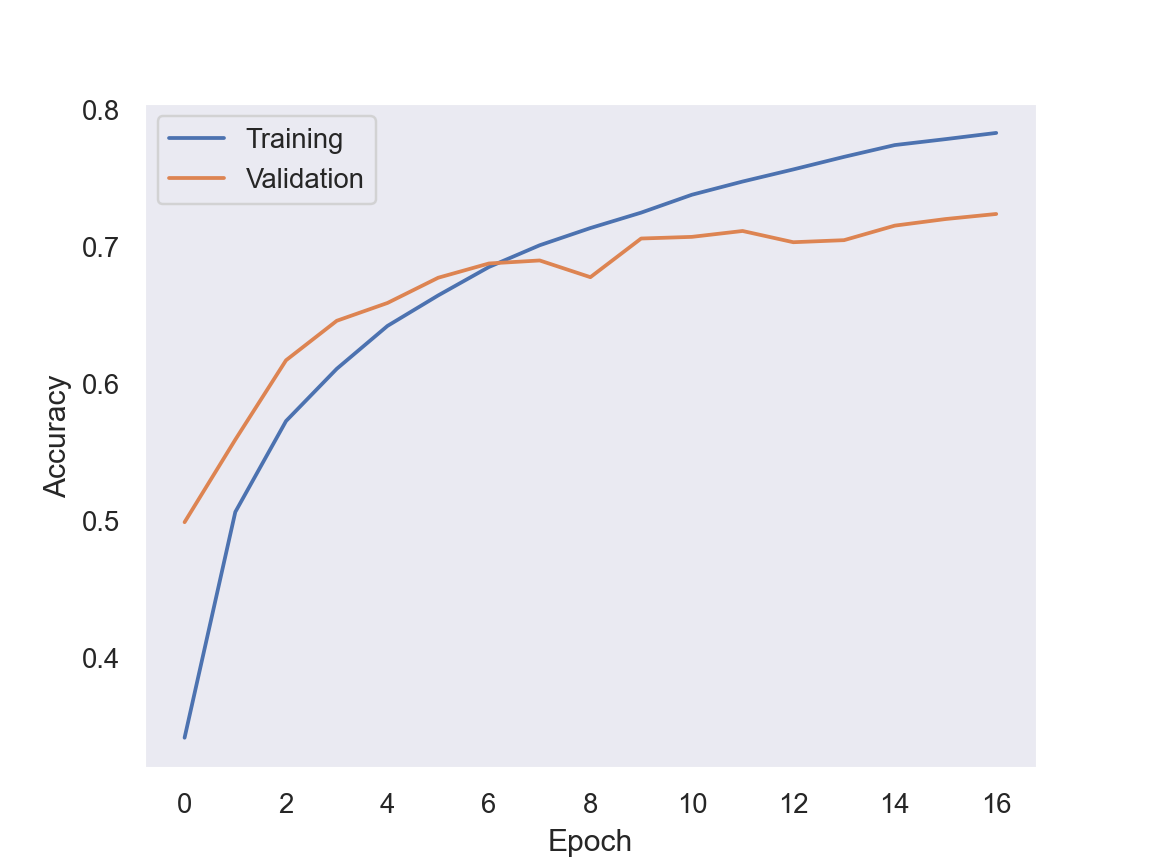

In [147]:
plt.figure()
plt.plot(history.history['accuracy'], label="Training")
plt.plot(history.history['val_accuracy'], label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [148]:
%%time
predictions = model.predict(validation_images)

313/313 [==============================] - 3s 8ms/step
CPU times: user 13.1 s, sys: 506 ms, total: 13.6 s
Wall time: 2.86 s


In [149]:
predicted_classes = np.argmax(predictions, axis=1)

<IPython.core.display.Javascript object>


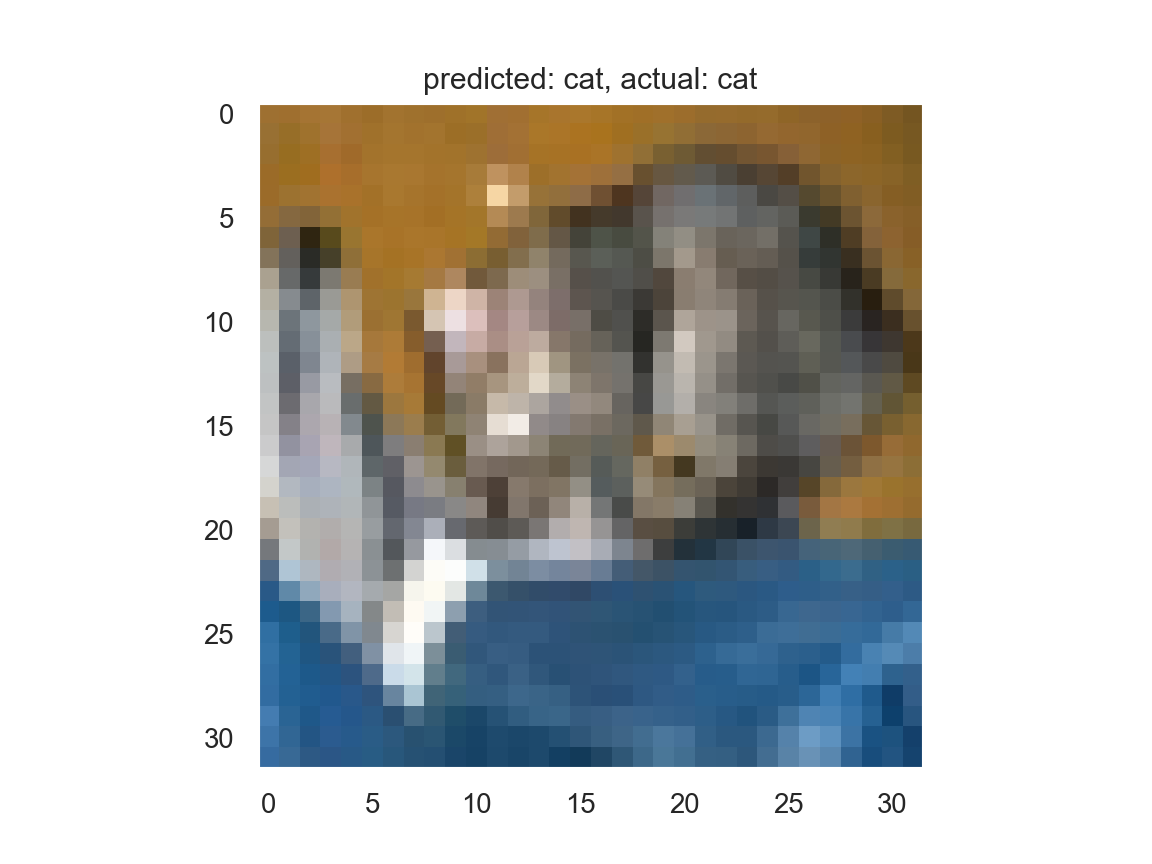

cat prob:  0.99999994
truck prob:  0.0
ship prob:  0.0
horse prob:  0.0
frog prob:  0.0
dog prob:  0.0
deer prob:  0.0
bird prob:  0.0
automobile prob:  0.0
airplane prob:  0.0


In [154]:
i = 0
plt.figure()
plt.rcParams["axes.grid"] = False  #  Remove the grid lines from the image.
plt.imshow(validation_images[i])
plt.title('predicted: %s, actual: %s' % (label_names[predicted_classes[i]], label_names[validation_labels[i]]))

imax = np.argsort(predictions[i])[::-1]
for l, p in zip(np.asarray(label_names)[imax], predictions[i][imax]):
    print(l, 'prob: ', p)

CNN model achieves 78% accuracy on training set, and 72% accuracy on validation set

## Inception model 

This next part of the notebook uses a previously trained model (inception model) to produce higher accuracy image classification

In [156]:
inception = tf.keras.applications.inception_v3.InceptionV3(include_top=True, input_shape=(299, 299, 3))
inception = tf.keras.Model([inception.input], [inception.layers[-2].output]) # discard prediction layer

In [157]:
def vectorize(train_images, batch_size, status=False):
    num_batches = len(train_images) // batch_size
    vectors = []
    
    for i in range(num_batches):
        batch = train_images[i*batch_size : (i+1)*batch_size]
        image = tf.image.resize(batch, (299, 299), method=tf.image.ResizeMethod.BILINEAR).numpy()
        vectors.append(inception.predict(image, verbose=0))
        
        if status:
            sys.stdout.write('\r Percent complete: %.2f' % (100*float(i)/num_batches))
            sys.stdout.flush()
    
    return np.concatenate(vectors)

In [158]:
#%%time
#batch_size = 10
#vectors_train = vectorize(x_train, batch_size, status=True)

 Percent complete: 99.98CPU times: user 5h 4min 12s, sys: 28min 56s, total: 5h 33min 8s
Wall time: 54min 59s


In [159]:
#pickle.dump(vectors_train, open( "train_vectors.p", "wb" ) )
vectors = pickle.load(open( "vectors.p", "rb" ) )

In [160]:
#%%time
#batch_size = 10
#vectors_test = vectorize(x_test, batch_size, status=True)

 Percent complete: 99.90CPU times: user 1h 18s, sys: 5min 44s, total: 1h 6min 2s
Wall time: 10min 49s


In [161]:
#pickle.dump(vectors_test, open( "test_vectors.p", "wb" ) )
validation_vectors = pickle.load(open( "validation_vectors.p", "rb" ) )

In [162]:
# Model parameters
n_classes = 10
batch_size = 50
n_epochs = 100
drop_rate = 0.5
hidden_size = 64

In [176]:
model = keras.models.Sequential()

In [177]:
model.add(keras.layers.Dropout(drop_rate))
model.add(keras.layers.Dense(hidden_size, activation='relu')) 
model.add(keras.layers.Dense(n_classes, activation='softmax')) 

In [178]:
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.SGD(learning_rate=0.1), #adam seems to do worse, does it just take longer to converge?
              metrics=['accuracy'])

In [179]:
checkpointer = keras.callbacks.ModelCheckpoint(filepath='./models/keras_example.hdf5',
                                               monitor='val_loss',
                                               verbose=1, save_best_only=True)
earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, min_delta=.01) 

In [180]:
%%time
history = model.fit(vectors_train, y_train,
                    epochs=n_epochs,
                    batch_size=batch_size,
                    callbacks=[checkpointer, earlystopping],
                    validation_data=(vectors_test,y_test))

Epoch 1/100
 998/1000 [============================>.] - ETA: 0s - loss: 0.8190 - accuracy: 0.7195
Epoch 1: val_loss improved from inf to 0.56374, saving model to ./models/keras_example.hdf5
1000/1000 [==============================] - 3s 2ms/step - loss: 0.8187 - accuracy: 0.7196 - val_loss: 0.5637 - val_accuracy: 0.8068
Epoch 2/100
 975/1000 [============================>.] - ETA: 0s - loss: 0.6444 - accuracy: 0.7785
Epoch 2: val_loss improved from 0.56374 to 0.54137, saving model to ./models/keras_example.hdf5
1000/1000 [==============================] - 2s 2ms/step - loss: 0.6439 - accuracy: 0.7781 - val_loss: 0.5414 - val_accuracy: 0.8142
Epoch 3/100
 987/1000 [============================>.] - ETA: 0s - loss: 0.6112 - accuracy: 0.7892
Epoch 3: val_loss improved from 0.54137 to 0.52607, saving model to ./models/keras_example.hdf5
1000/1000 [==============================] - 2s 2ms/step - loss: 0.6109 - accuracy: 0.7893 - val_loss: 0.5261 - val_accuracy: 0.8168
Epoch 4/100
 984/100

1000/1000 [==============================] - 2s 2ms/step - loss: 0.4863 - accuracy: 0.8300 - val_loss: 0.4787 - val_accuracy: 0.8317
Epoch 29/100
 983/1000 [============================>.] - ETA: 0s - loss: 0.4850 - accuracy: 0.8296
Epoch 29: val_loss did not improve from 0.45680
1000/1000 [==============================] - 2s 2ms/step - loss: 0.4840 - accuracy: 0.8299 - val_loss: 0.4752 - val_accuracy: 0.8348
Epoch 30/100
 991/1000 [============================>.] - ETA: 0s - loss: 0.4783 - accuracy: 0.8339
Epoch 30: val_loss did not improve from 0.45680
1000/1000 [==============================] - 2s 2ms/step - loss: 0.4781 - accuracy: 0.8338 - val_loss: 0.4577 - val_accuracy: 0.8426
Epoch 31/100
 996/1000 [============================>.] - ETA: 0s - loss: 0.4726 - accuracy: 0.8326
Epoch 31: val_loss did not improve from 0.45680
1000/1000 [==============================] - 2s 2ms/step - loss: 0.4730 - accuracy: 0.8325 - val_loss: 0.4607 - val_accuracy: 0.8426
Epoch 32/100
 994/1000 [

<IPython.core.display.Javascript object>


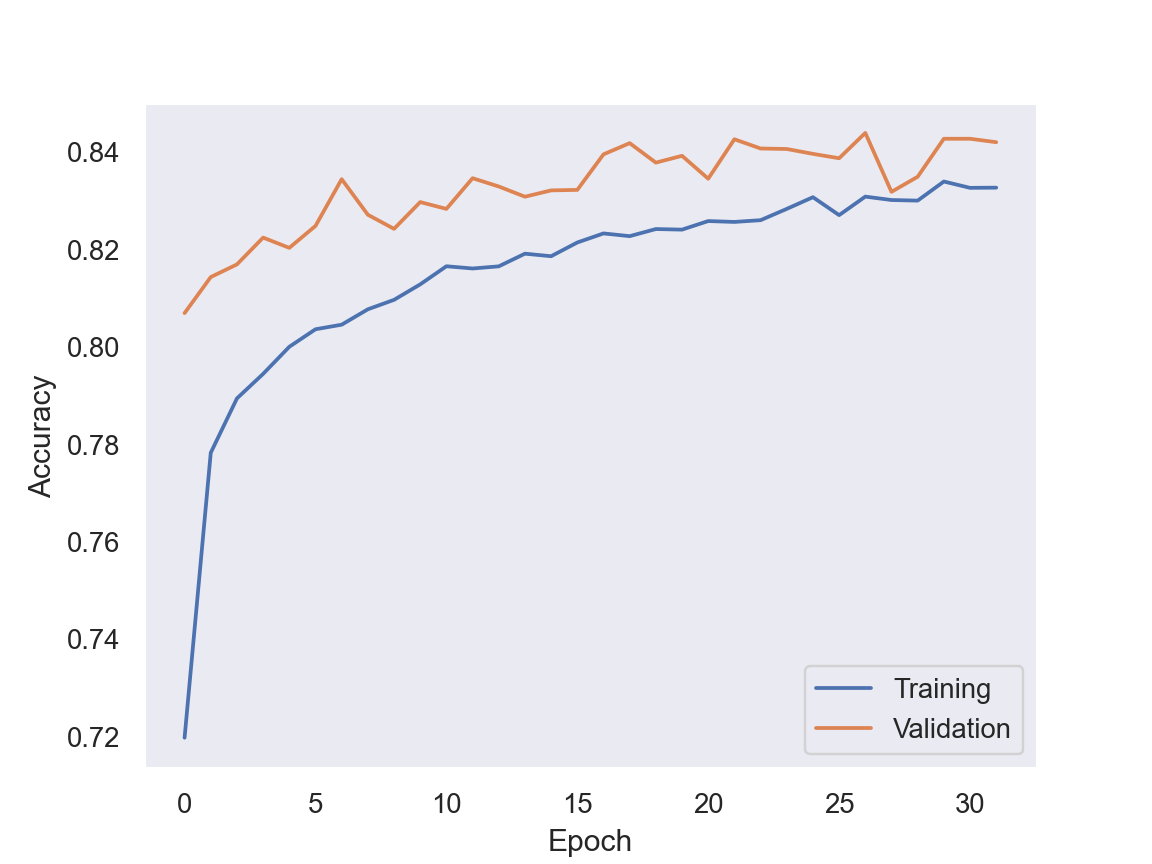

In [185]:
plt.figure()
plt.plot(history.history['accuracy'], label="Training")
plt.plot(history.history['val_accuracy'], label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [182]:
%%time
predictions = model.predict(vectors_test)

313/313 [==============================] - 0s 1ms/step
CPU times: user 675 ms, sys: 93.7 ms, total: 769 ms
Wall time: 531 ms


In [183]:
predicted_classes = np.argmax(predictions, axis=1)

<IPython.core.display.Javascript object>


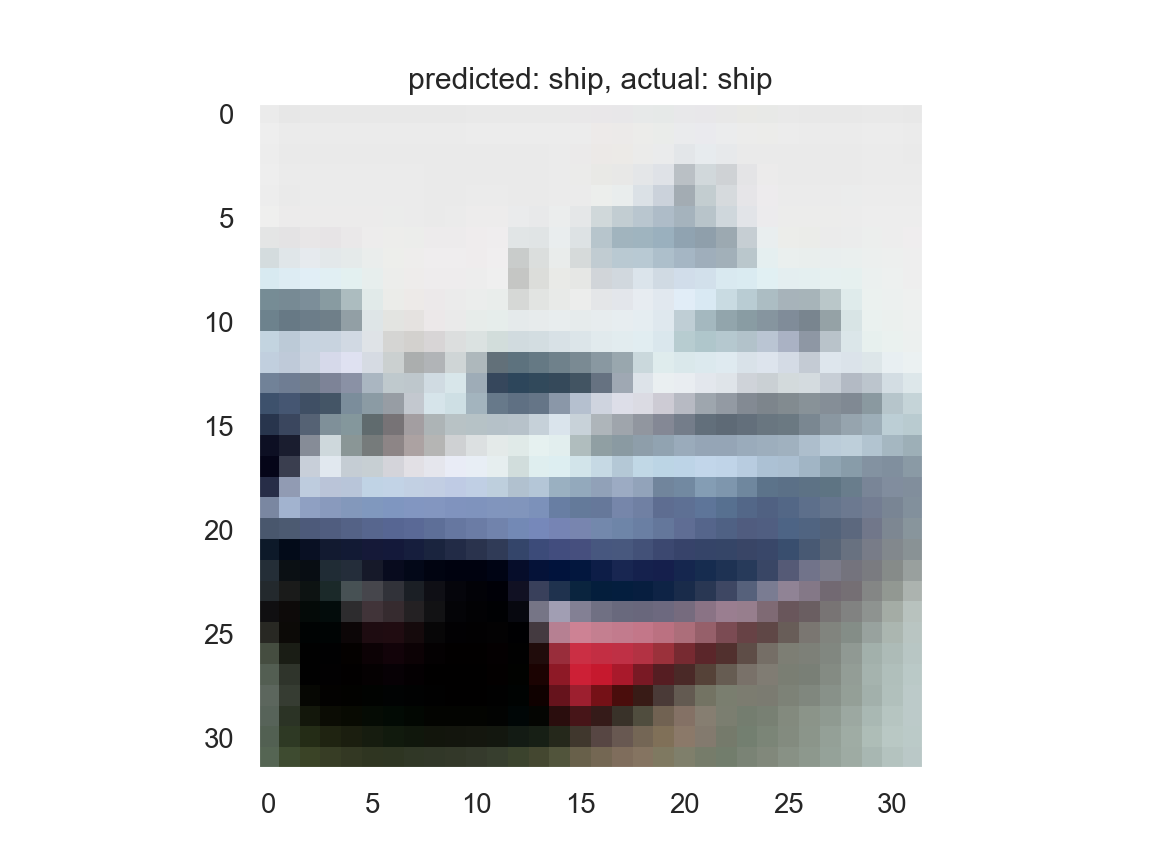

ship prob:  0.99114156
airplane prob:  0.007913407
automobile prob:  0.00085135945
truck prob:  6.510127e-05
bird prob:  2.245516e-05
horse prob:  3.420134e-06
cat prob:  1.3150892e-06
frog prob:  6.9042665e-07
dog prob:  3.412567e-07
deer prob:  2.7547242e-07


In [184]:
i = 1
plt.figure()
plt.rcParams["axes.grid"] = False  #  Remove the grid lines from the image.
plt.imshow(validation_images[i])
plt.title('predicted: %s, actual: %s' % (label_names[predicted_classes[i]], label_names[validation_labels[i]]))

imax = np.argsort(predictions[i])[::-1]
for l, p in zip(np.asarray(label_names)[imax], predictions[i][imax]):
    print(l, 'prob: ', p)

CNN model achieves 83% accuracy on training set, and 84% accuracy on validation set